In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from hmmlearn.hmm import GaussianHMM

Скачайте текст войны и мир. Очистите его, оставив только русские буквы и символы пробела.

In [2]:
def read_tom(file_name):
    with open(file_name, 'r', encoding='utf-8') as f:
        tom = f.read().lower()
    tom = re.sub('[^а-я\s\-]','', tom)
    tom = re.sub('\n+',' ', tom)
    tom = re.sub('\-',' ', tom)
    tom = re.sub('\s+',' ', tom)
    return tom

In [3]:
tom_1 = read_tom('tom_1.txt')
tom_2 = read_tom('tom_2.txt')
tom_3 = read_tom('tom_3.txt')
tom_4 = read_tom('tom_4.txt')

In [4]:
text = tom_1 + ' ' + tom_2 + ' ' + tom_3 + ' ' + tom_4

Постройте матрицу переходных вероятностей.

In [5]:
RUSSIAN = 'абвгдежзийклмнопрстуфхцчшщъыьэюя '
RUSSIAN_LET = 'абвгдежзийклмнопрстуфхцчшщъыьэюя'
POS = {l: i for i, l in enumerate(RUSSIAN)}

In [6]:
probabilities = np.zeros((len(RUSSIAN), len(RUSSIAN)))

In [7]:
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1

In [8]:
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

In [9]:
df = pd.DataFrame(probabilities, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))

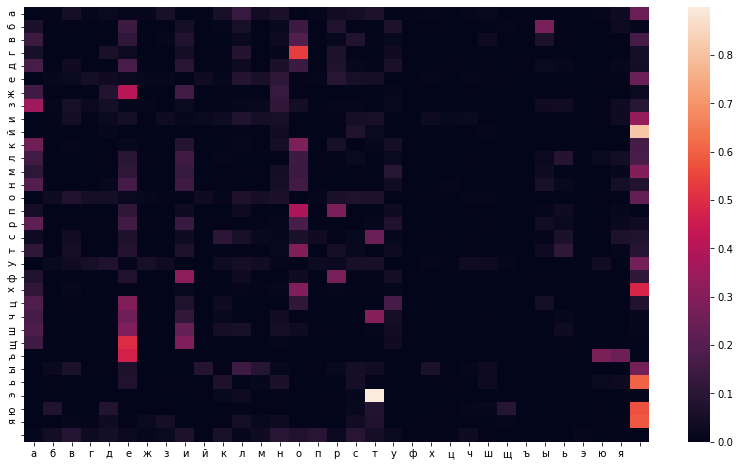

In [10]:
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

Посчитайте вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р.

In [11]:
letter_1 = 'п'
letter_4 = 'р'
prior = 1. / (len(RUSSIAN)-1)
sum_proba = 0
max_proba = 0
max_word = ''

for letter_2 in 'о':
    for letter_3 in RUSSIAN:
        if (letter_2 != ' ') & (letter_3 != ' '):
            proba = prior * probabilities[POS[letter_1], POS[letter_2]] * \
            probabilities[POS[letter_2], POS[letter_3]] * probabilities[POS[letter_3], POS[letter_4]]
            if proba > max_proba:
                max_proba = proba
                max_word = ''.join([letter_1, letter_2, letter_3, letter_4])
        else:
            proba = 0
        sum_proba += proba
print(sum_proba)
print(max_word)

0.0002742039463566324
потр


Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы “Б” и имеющее длину 8-мь символов.

In [21]:
# 32^7 итераций занимают очень много времени, поэтому будем считать, что за буквой 'б' идёт буква 'о',
# а за буквой 'о' идёт одна из букв 'л', 'н' или 'р'

letter_1 = 'б'
letter_9 = ' '
max_proba = 0
max_word = ''
prior = 1. / (len(RUSSIAN)-1)

for letter_2 in 'а':
    for letter_3 in 'с':
        for letter_4 in tqdm(RUSSIAN_LET):
            for letter_5 in RUSSIAN_LET:
                for letter_6 in RUSSIAN_LET:
                    for letter_7 in RUSSIAN_LET:
                        for letter_8 in RUSSIAN_LET:
                            proba = prior * \
                            probabilities[POS[letter_1], POS[letter_2]] * \
                            probabilities[POS[letter_2], POS[letter_3]] * \
                            probabilities[POS[letter_3], POS[letter_4]] * \
                            probabilities[POS[letter_4], POS[letter_5]] * \
                            probabilities[POS[letter_6], POS[letter_7]] * \
                            probabilities[POS[letter_7], POS[letter_8]] * \
                            probabilities[POS[letter_8], POS[letter_9]] 
                            if proba > max_proba:
                                max_proba = proba
                                max_word = ''.join([letter_1, letter_2, letter_3, letter_4, letter_5,
                                                    letter_6, letter_7, letter_8])
print(max_word)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:56<00:00,  3.63s/it]

бастоэто


Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM. Попробуйте “построить” (через среднее каждой компоненты) наивный прогноз ряда.

In [13]:
series = pd.read_csv("monthly-boston-armed-robberies-j.csv")["Count"]

In [14]:
values = series.values.reshape(-1,1)

In [18]:
for n in range(1, 12):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

1 -739.512376545524
2 -652.7824661820224
3 -629.4670322744707
4 -593.9630465273634
5 -577.8455484968264
6 -571.3182247583842


Fitting a model with 119 free scalar parameters with only 118 data points will result in a degenerate solution.


7 -561.1297217988865
8 -557.252133848463
9 -554.9655051223991


Fitting a model with 142 free scalar parameters with only 118 data points will result in a degenerate solution.


10 -552.0294680212634
11 -546.7857886317822


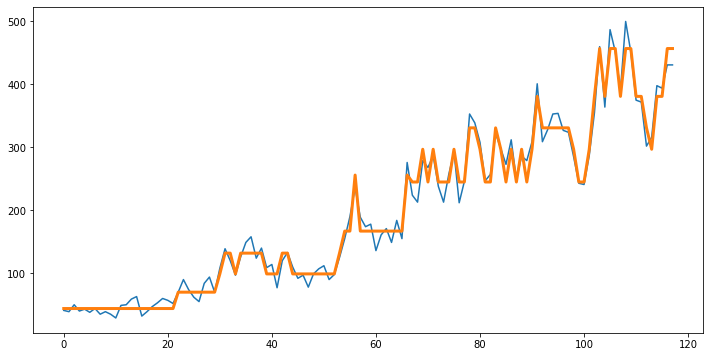

In [19]:
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)